# Credit Card Customer Segmentation using K-Means

### Business Understanding

Creating a customer segmentation is essential for developing a successful marketing strategy. The dataset provided contains usage patterns from the last 6 months for about 9000 active credit card holders. This dataset is structured at the customer level and encompasses 18 distinct behavioral variables.

Data set: https://www.kaggle.com/arjunbhasin2013/ccdata

### Data Understanding

### Pre-Processing Data

**Import library and dataset**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [65]:
import pandas as pd

def describe_more(data, normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be a list"
    if weight_column is not None:
        if weight_column not in list(data.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in data:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(data[x], dropna=dropna))
            uniq_counts = len(pd.value_counts(data[x], dropna=dropna)[pd.value_counts(data[x], dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( data[ x ].dtypes )
            min_l.append(data[x].apply(str).str.len().min())
            max_l.append(data[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                data2 = data.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                data2['authtrans_vts_cnt']=((data2[weight_column])/data2[weight_column].sum()).round(2)
                unq.append(data2.head(n=100).to_dict()[weight_column])
            else:
                data_cat_d = data[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                data_cat_d = data_cat_d[data_cat_d>0]
                unq.append(data_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [66]:
df_cc = pd.read_csv('CC GENERAL.csv')
df_cc.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [67]:
df_cc.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [68]:
df_cc.shape

(8950, 18)

In [69]:
describe_more(df_cc)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,CUST_ID,8950,object,6,6,"{'C10001': 1, 'C16135': 1, 'C16129': 1, 'C1613..."
1,BALANCE,8871,float64,3,11,"{0.0: 80, 40.900749: 1, 1213.551338: 1, 1253.1..."
2,BALANCE_FREQUENCY,43,float64,3,8,"{1.0: 6211, 0.909091: 410, 0.818182: 278, 0.72..."
3,PURCHASES,6203,float64,3,8,"{0.0: 2044, 45.65: 27, 60.0: 16, 150.0: 16, 30..."
4,ONEOFF_PURCHASES,4014,float64,3,8,"{0.0: 4302, 45.65: 46, 50.0: 17, 200.0: 15, 60..."
5,INSTALLMENTS_PURCHASES,4452,float64,3,8,"{0.0: 3916, 300.0: 14, 200.0: 14, 100.0: 14, 1..."
6,CASH_ADVANCE,4323,float64,3,11,"{0.0: 4628, 495.425832: 1, 1486.243293: 1, 855..."
7,PURCHASES_FREQUENCY,47,float64,3,8,"{1.0: 2178, 0.0: 2043, 0.083333: 677, 0.916667..."
8,ONEOFF_PURCHASES_FREQUENCY,47,float64,3,8,"{0.0: 4302, 0.083333: 1104, 0.166667: 592, 1.0..."
9,PURCHASES_INSTALLMENTS_FREQUENCY,47,float64,3,8,"{0.0: 3915, 1.0: 1331, 0.416667: 388, 0.916667..."


**Please note**: While there are numerous outliers (indicated by the maximum values), it is crucial not to exclude them, as they could potentially hold significant insights. Thus, we handle these outliers as exceptional data points.

**Checking Null Values**

In [70]:
df_cc.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Note**: The variables CREDIT_LIMIT and MINIMUM_PAYMENT contain some null values. To address this issue, we will fill in the missing values by using their respective means.

In [71]:
df_cc['CREDIT_LIMIT'].fillna(df_cc['CREDIT_LIMIT'].mean(), inplace=True)
df_cc['MINIMUM_PAYMENTS'].fillna(df_cc['MINIMUM_PAYMENTS'].mean(), inplace=True)

**Checking again**

In [72]:
df_cc.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

All null values have been successfully resolved.

In [73]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

**Note :** CUST_ID has data types object, so we will drop it.

In [74]:
df_cc.drop('CUST_ID', axis=1, inplace=True)


### Data Normalization

In [75]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df_cc) 

In [76]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

### Dimension Reduction using PCA

We apply Principal Component Analysis (PCA) to transform data to 2 dimensions for visualization because we won't be able to visualize the data in 17 dimensions. PCA transforms a large set of variables into a smaller one that still contains most of the information in the large set. Reducing the number of variables of a data.

In [77]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(2)

,P1,P2
0,-0.489826,-0.679678
1,-0.518791,0.545011


### Clustering

#### Choosing the K

**SSE**

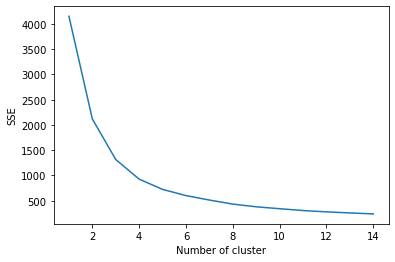

In [78]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use **silhouette score**.

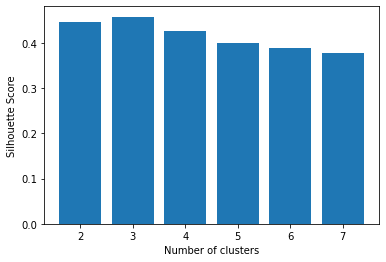

In [79]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

**Note :** Highest silhouette score is **k = 3**.

In [80]:
kmean= KMeans(3)
kmean.fit(scaled_df)
labels=kmean.labels_

In [81]:
clusters=pd.concat([df_cc, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


**Interpretation of Cluster**

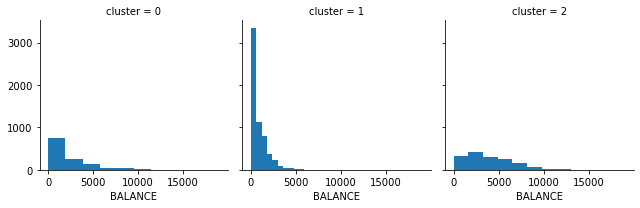

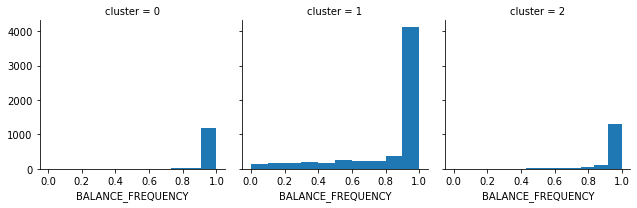

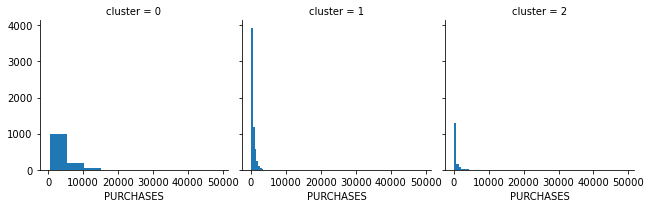

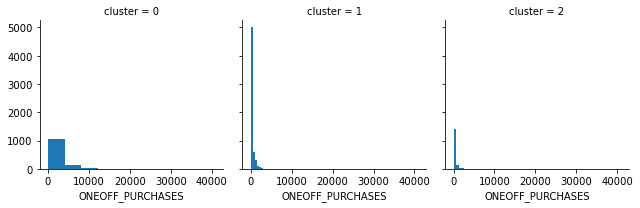

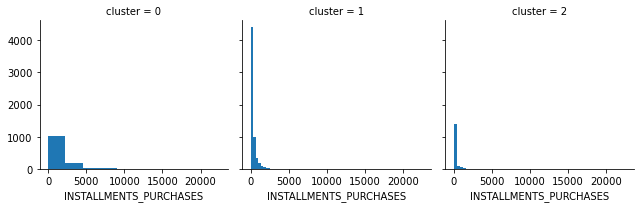

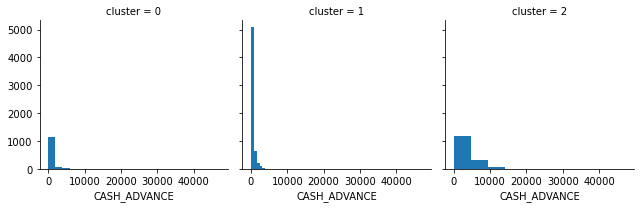

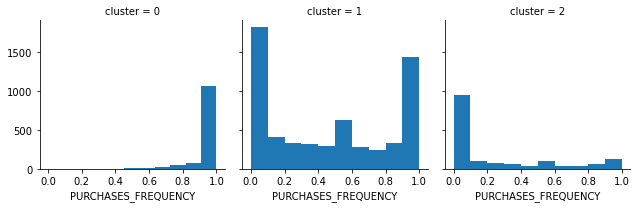

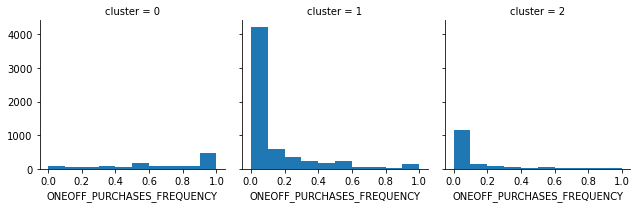

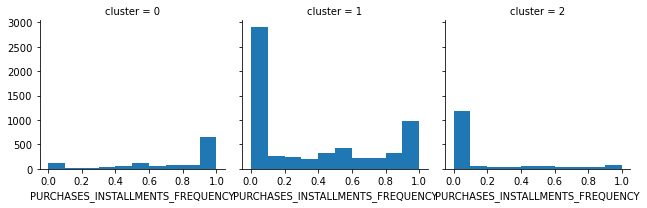

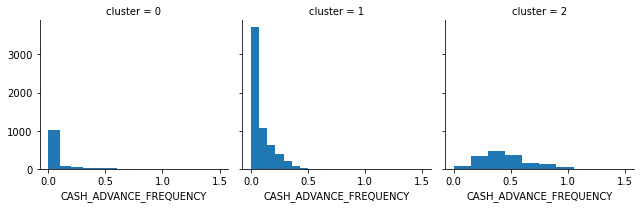

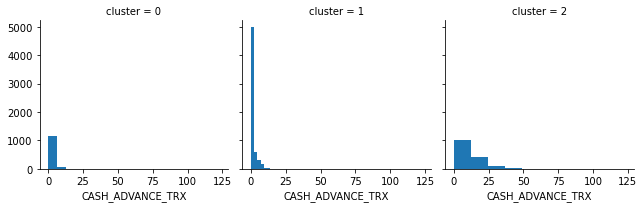

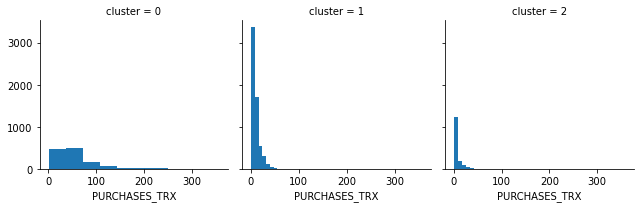

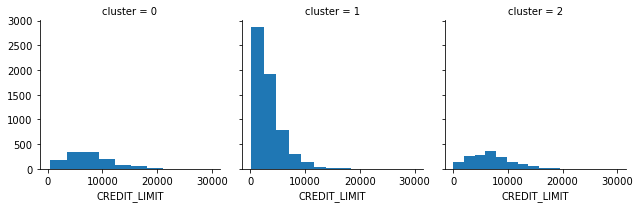

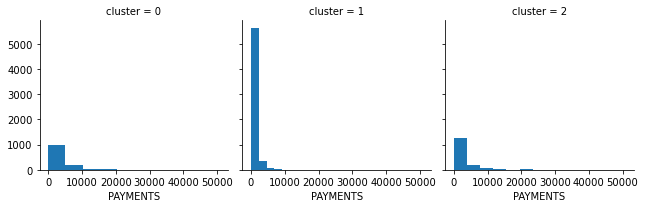

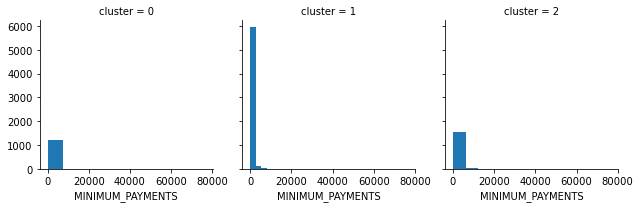

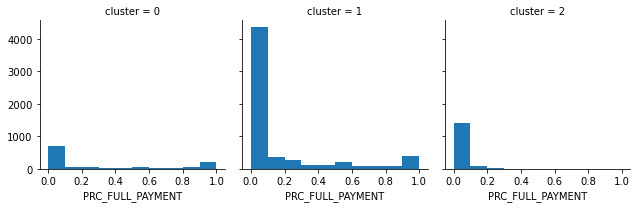

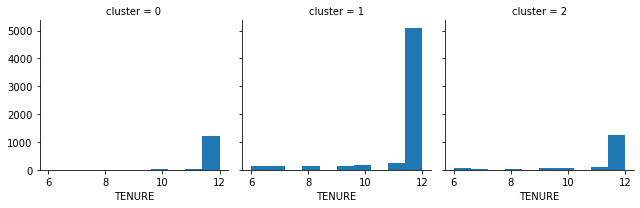

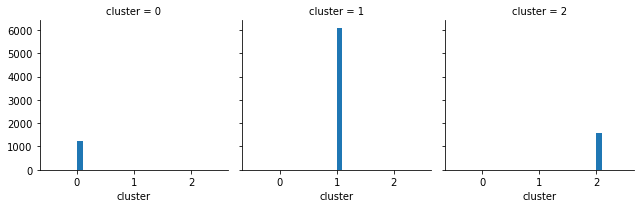

In [82]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [83]:
clusters['cluster'].value_counts()

1    6103
2    1595
0    1252
Name: cluster, dtype: int64

In [84]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,2197.296209,0.981438,4233.043267,2697.663874,1535.858626,455.603491,0.948701,0.669259,0.739333,0.062830,1.523163,56.112620,7687.659744,4118.077849,1214.668536,0.301078,11.916933
1,800.461057,0.834815,502.180541,250.346708,252.155471,330.479456,0.463577,0.130595,0.344889,0.068357,1.212355,8.588727,3266.732432,907.867214,548.679183,0.154824,11.478945
2,3991.110361,0.957954,385.018966,248.886107,136.210395,3870.573521,0.233011,0.111012,0.144960,0.447457,12.395611,5.631975,6685.582787,3018.865455,1796.422881,0.033796,11.350470


### Cluster Interpretation

**Cluster 0**

**Cluster 1**

**Cluster 2**

### Visualization

In [85]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf.head(2)

,principal component 1,principal component 2
0,-0.489826,-0.679678
1,-0.518791,0.545012


In [86]:
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)
finalDf.head()

,principal component 1,principal component 2,cluster
0,-0.489826,-0.679678,1
1,-0.518791,0.545012,2
2,0.330885,0.268976,1
3,-0.482374,-0.092109,1
4,-0.563289,-0.481915,1


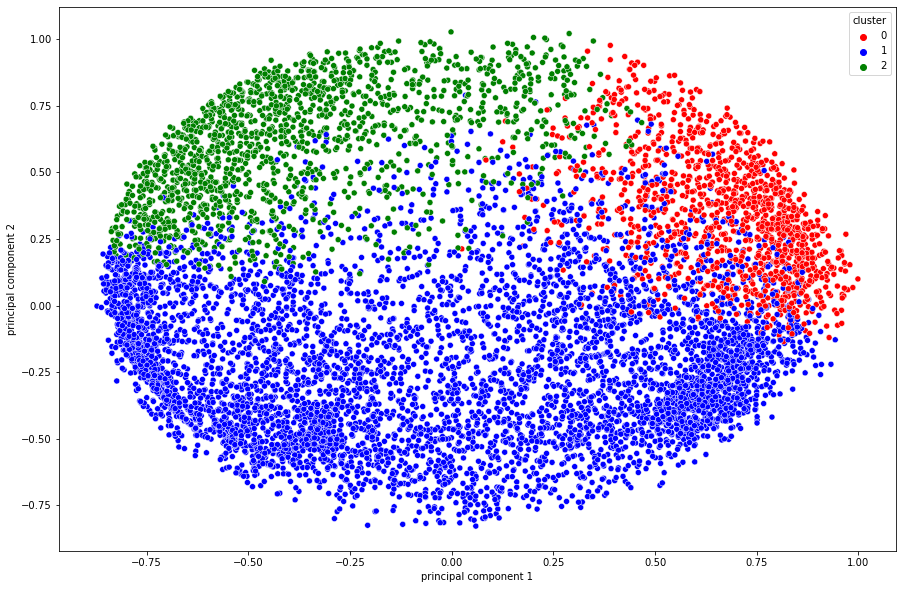

In [87]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','blue','green'])
plt.show()

### Conclusion


* **Cluster 0 :** This customer group indicates a large group of customers who have low balances, small spenders with the lowest credit limit. 

* **Cluster 1 :** This customer group indicates a small group of customers who have medium balances, spenders with the highest credit limit.

* **Cluster 2 :** This customer group indicates a small group of customers who have high balances and cash advances, low purchase frequency with high credit limit. We can assume that this customer segment uses their credit cards as a loan.
